# Title

Short description of what this notebook is about

## Preliminaries

Here's a high-level outline of the notebook:

Introduction and Setup

    Introduction to the project.
    Import necessary libraries (SimPy, pandas, matplotlib, etc.).

Define the Simulation Environment

    Create the environment.
    Define resources such as staff and treatment rooms.


Define Processes

    Patient arrival.
    Registration process.
    Triage process.
    Treatment process.
    Discharge process.

Run the Simulation

    Generate patient arrivals.
    Collect data on patient wait times and system throughput.

Analyze the Results

    Calculate key metrics (average wait time, time in system, etc.).
    Plot histograms and summary statistics.

1. Import Libraries

In [4]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

2. Define the Patient Class

In [5]:
class Patient:
    def __init__(self, patient_id, env):
        self.patient_id = patient_id
        self.env = env
        self.arrival_time = env.now
        self.wait_for_triage = 0
        self.wait_for_treatment = 0
        self.time_in_system = 0


3. Define the ER Processes

In [6]:
def patient_arrival(env, patient_id, er):
    patient = Patient(patient_id, env)
    with er.triage_nurse.request() as request:
        yield request
        patient.wait_for_triage = env.now - patient.arrival_time
        yield env.process(triage(patient))

    with er.doctor.request() as request:
        yield request
        patient.wait_for_treatment = env.now - (patient.arrival_time + patient.wait_for_triage)
        yield env.process(treatment(patient))

    patient.time_in_system = env.now - patient.arrival_time
    er.patient_log.append(patient)

def triage(patient):
    yield env.timeout(random.randint(5, 10))

def treatment(patient):
    yield env.timeout(random.randint(20, 40))


4. Define the ER Environment


In [7]:
class EmergencyRoom:
    def __init__(self, env):
        self.env = env
        self.triage_nurse = simpy.Resource(env, capacity=2)
        self.doctor = simpy.Resource(env, capacity=2)
        self.patient_log = []

def run_er(env, er):
    patient_id = 0
    while True:
        yield env.timeout(random.expovariate(1/5))
        env.process(patient_arrival(env, patient_id, er))
        patient_id += 1


5. Run the Simulation


In [8]:
env = simpy.Environment()
er = EmergencyRoom(env)
env.process(run_er(env, er))
env.run(until=480)  # Run for 8 hours (480 minutes)


6. Analyze the Results


       patient_id  wait_for_triage  wait_for_treatment  time_in_system
count   29.000000        29.000000           29.000000       29.000000
mean    14.000000         4.028893          157.161273      191.672925
std      8.514693         4.191881           91.412877       92.831639
min      0.000000         0.000000            5.000000       44.000000
25%      7.000000         0.000000           87.365849      116.599034
50%     14.000000         2.261213          150.692447      194.769537
75%     21.000000         6.153792          233.397276      270.447830
max     28.000000        14.249595          303.567561      348.646871


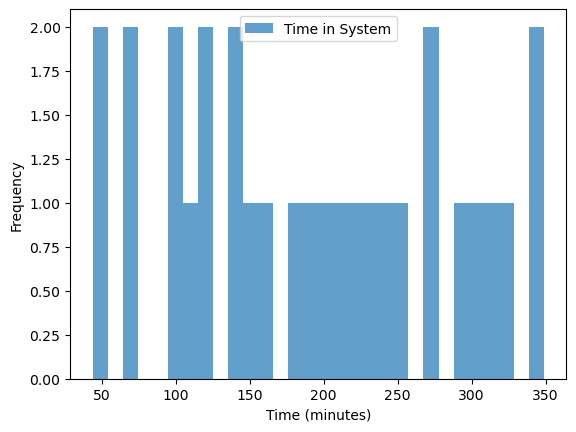

In [9]:
# Collect data
data = {
    "patient_id": [],
    "wait_for_triage": [],
    "wait_for_treatment": [],
    "time_in_system": []
}

for patient in er.patient_log:
    data["patient_id"].append(patient.patient_id)
    data["wait_for_triage"].append(patient.wait_for_triage)
    data["wait_for_treatment"].append(patient.wait_for_treatment)
    data["time_in_system"].append(patient.time_in_system)

df = pd.DataFrame(data)

# Summary statistics
print(df.describe())

# Plot histograms
plt.hist(df["time_in_system"], bins=30, alpha=0.7, label='Time in System')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
